# Proyecto Encoders

Andre Yahir Gonzalez Cuevas

Este proyecto trata sobre poner en practica los conocimientos adquiridos hasta ahora sobre los Encoders, tanto su funcionamiento como su implementacion en distitnos proyectos.

Este proyecto se basa en la base de datos FFQH, el cual consta de datos consta de 52.000 imágenes PNG de alta calidad con una resolución de 512 × 512 y contiene una variación considerable en términos de edad, origen étnico y fondo de la imagen.

También tiene una buena cobertura de accesorios como anteojos, gafas de sol, sombreros, etc. Las imágenes fueron rastreadas desde Flickr, heredando así todos los sesgos de ese sitio web, y alineadas y recortadas automáticamente usando dlib. Sólo se recopilaron imágenes bajo licencias permisivas. Se utilizaron varios filtros automáticos para podar el conjunto, y finalmente se utilizó Amazon Mechanical Turk para eliminar alguna que otra estatua, pintura o fotografía de fotografías.

El dataset origanl tiene un peso de 2.5Tb por lo tanto se usará otra version llamada thumbnails128x128, la cual solo pesa 1.95 GB y contiene 70,000 imagenes, por lo tanto se usará este dataset, de todas formas se le haran cambios a los datos.

Uno de los cambios que se haran será cambiar la calidad por cuestiones de procesamiento y tiempos de ejecucion uno de estos es bajar la calidad de 255x255 a 64x64, de la misma forma se hará usará un porcentaje del total de datos por cuestiones de almacenamiento en este caso se usará el 15% del to
tal de imagenes.

El objetivo de este proyecto es hacer un autocnoder el cual pueda, recibir imagenes las cuales tengan distintos tipo de ruidos y con ayuda del autoencoder se pueda limpiar y suavizar las imagenes y eliminar el ruido generado.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch.cuda
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import datasets, transforms

import os

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? False


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Proyecto_encoders/archive.zip' -d '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Proyecto_encoders'

Lo primero que hacemos es seleccionar las imagenes que se van a usar y modificarlas para que sean de 64x64, despues de esto se separaran en train y test.

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import shutil

# Función para cargar las imágenes
def load_images_from_folder(folder, target_size=(64, 64)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            # Redimensionar la imagen
            img = img.resize(target_size)
            # Convertir a formato RGB y asegurarse de que tenga solo 3 canales
            img = img.convert('RGB')
            images.append(np.array(img))
            # Asigna una etiqueta (por ejemplo, 0 para entrenamiento, 1 para prueba)
            labels.append(0 if random.random() < 0.8 else 1)
    return images, labels

# Directorio donde están tus imágenes
root_directory = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Proyecto_encoders/train/selected_thumbnails128x128'

# Cargar las imágenes y las etiquetas
images, labels = load_images_from_folder(root_directory)

# Dividir las imágenes y las etiquetas en conjuntos de entrenamiento y prueba
x_train = []
y_train = []
x_test = []
y_test = []

for img, label in zip(images, labels):
    if label == 0:
        x_train.append(img)
        y_train.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

# Convertir listas a numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print('Dimensiones de x_train:', x_train.shape)
print('Dimensiones de y_train:', y_train.shape)
print('Dimensiones de x_test:', x_test.shape)
print('Dimensiones de y_test:', y_test.shape)


Dimensiones de x_train: (2979, 64, 64, 3)
Dimensiones de y_train: (2979,)
Dimensiones de x_test: (782, 64, 64, 3)
Dimensiones de y_test: (782,)


In [ ]:
x_train = x_train.astype('float32') / 255
y_train = y_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_test = y_test.astype('float32') / 255

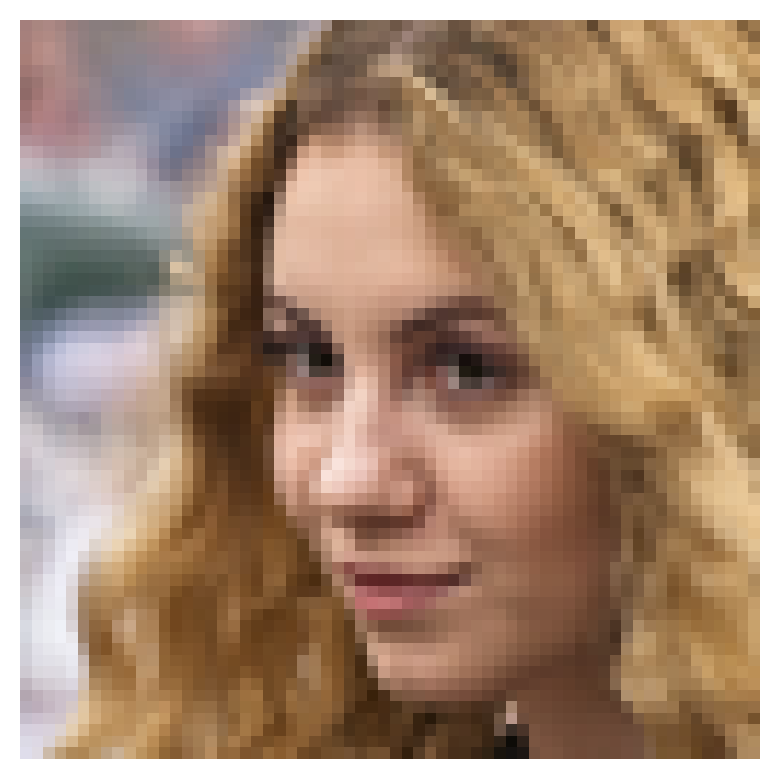

In [ ]:
# Convertir el lote de imágenes a un arreglo NumPy
images = x_train

# Seleccionar una imagen aleatoria del lote
index = np.random.randint(len(images))
image = images[20]
plt.imshow(image)
plt.axis('off')
plt.show()

Ahora probaremos agregarle diferentes tipos de ruido a las imagenes para poder probar el encoder y su comportamiento antes las diferentes imagenes

In [ ]:
# Código para agregar ruido a las imágenes y generar las imágenes con ruido directamente
noise_factor = 0.15
# Generación de imágenes con ruido para el conjunto de entrenamiento
x_train_noisy = np.array([image + noise_factor * np.random.normal(size=image.shape) for image in x_train])
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)

# Generación de imágenes con ruido para el conjunto de prueba
x_test_noisy = np.array([image + noise_factor * np.random.normal(size=image.shape) for image in x_test])
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

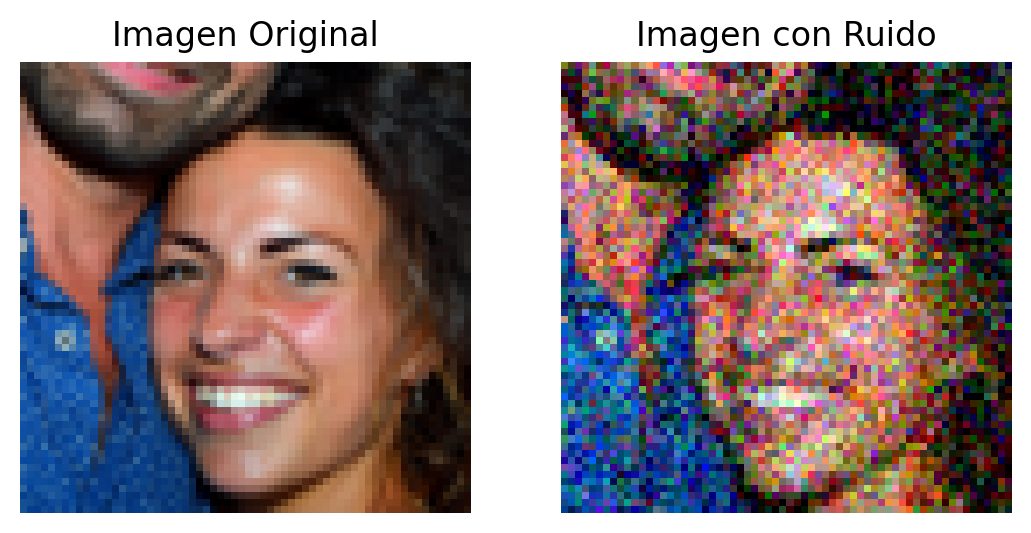

In [ ]:
index = np.random.randint(0, len(x_train_noisy))
plt.subplot(1, 2, 1)
plt.imshow(x_train[index])
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_train_noisy[index])
plt.title('Imagen con Ruido')
plt.axis('off')

plt.show()

In [ ]:
# Código para agregar ruido de tipo Poisson a las imágenes y generar las imágenes con ruido directamente
lambda_factor = 0.08  # Parámetro lambda para la distribución de Poisson

# Generación de imágenes con ruido para el conjunto de entrenamiento
x_train_noisy_Poisson = np.array([np.random.poisson(image / (1.0 / lambda_factor)) * (1.0 / lambda_factor) for image in x_train])
x_train_noisy_Poisson = np.clip(x_train_noisy, 0.0, 1.0)

# Generación de imágenes con ruido para el conjunto de prueba
x_test_noisy_Poisson = np.array([np.random.poisson(image / (1.0 / lambda_factor)) * (1.0 / lambda_factor) for image in x_test])
x_test_noisy_Poisson = np.clip(x_test_noisy, 0.0, 1.0)


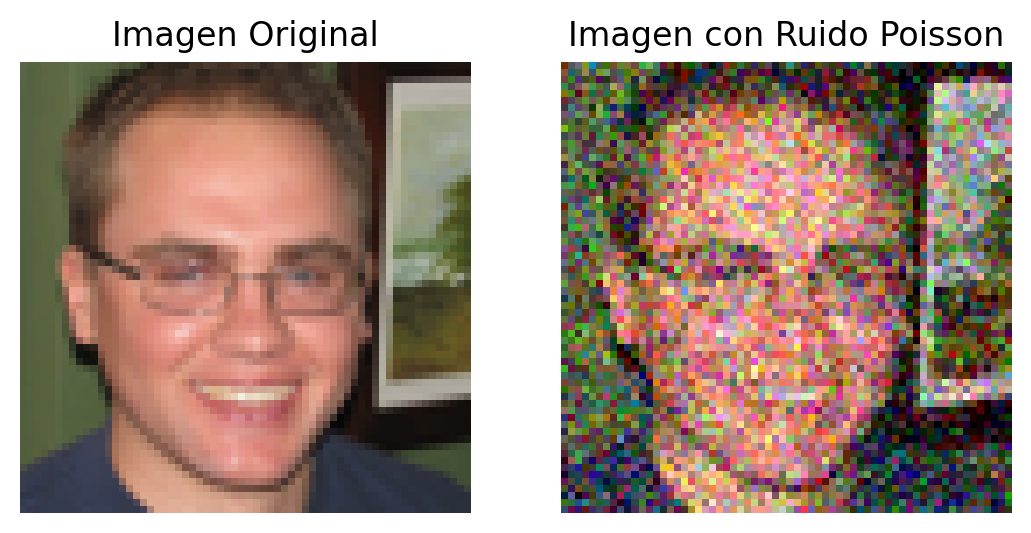

In [ ]:
index = np.random.randint(0, len(x_train_noisy))
plt.subplot(1, 2, 1)
plt.imshow(x_train[index])
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_train_noisy_Poisson[index])
plt.title('Imagen con Ruido Poisson')
plt.axis('off')

plt.show()

In [ ]:
# Código para agregar ruido de tipo masking a las imágenes y generar las imágenes con ruido directamente
masking_factor = 0.5  # Factor de máscara para el ruido

# Generación de imágenes con ruido para el conjunto de entrenamiento
x_train_noisy_masking = np.array([image * np.random.choice([0, 1], size=image.shape, p=[masking_factor, 1 - masking_factor]) for image in x_train])

# Generación de imágenes con ruido para el conjunto de prueba
x_test_noisy_masking = np.array([image * np.random.choice([0, 1], size=image.shape, p=[masking_factor, 1 - masking_factor]) for image in x_test])


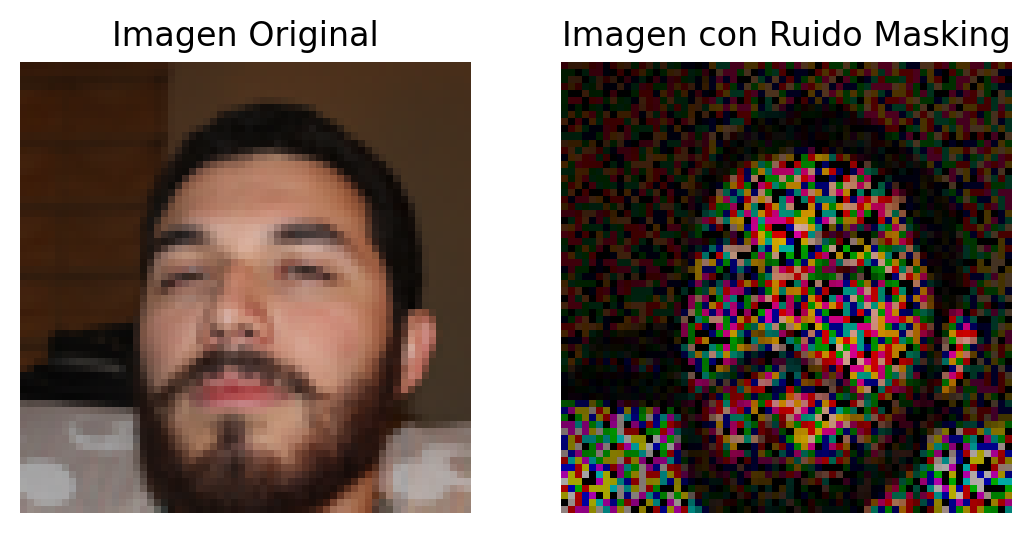

In [ ]:
index = np.random.randint(0, len(x_train_noisy))
plt.subplot(1, 2, 1)
plt.imshow(x_train[index])
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_train_noisy_masking[index])
plt.title('Imagen con Ruido Masking')
plt.axis('off')

plt.show()

In [ ]:
x_train[0].shape

(64, 64, 3)

La arquitectura de un autoencoder para quitar el ruido de imágenes es la siguiente:

Capa de entrada (input_img):

Define el tamaño de las imágenes de entrada como 64x64 píxeles con 3 canales de color (RGB).
Encoder:

Comienza con una capa convolucional (Conv2D) con 16 filtros de 3x3 y activación ReLU, lo que ayuda a extraer características de la imagen original.
Después de la convolución, se aplica una capa de pooling (MaxPooling2D) con un tamaño de ventana de 2x2, lo que reduce la dimensión espacial de la imagen a la mitad, conservando las características más importantes.
Se aplica una capa de Dropout para regularización, lo que ayuda a prevenir el sobreajuste.
Este proceso se repite varias veces, aumentando gradualmente el número de filtros y reduciendo la dimensión espacial de la imagen.
Latent Space (encoded):

El resultado final del encoder es una representación comprimida de la imagen original, llamada espacio latente. Esta representación tiene una dimensión reducida en comparación con la imagen original y contiene solo las características más importantes.
Decoder:

Comienza con una capa de convolución (Conv2D) con 32 filtros de 3x3 y activación ReLU. Esta capa ayuda a reconstruir la imagen a partir de la representación comprimida.
Después de la convolución, se aplica una capa de upsampling (UpSampling2D) con un tamaño de ventana de 2x2, lo que aumenta la dimensión espacial de la imagen.
Se repite este proceso de upsampling y convolución varias veces, con el objetivo de aumentar gradualmente la resolución de la imagen y reconstruir los detalles perdidos durante la compresión.
Capa de salida (decoded):

La capa final del decoder es una convolución con 3 filtros de 3x3 y activación sigmoide. Esta capa produce la imagen reconstruida, que debe ser lo más similar posible a la imagen original, después de pasar por el encoder y el decoder.
Compilación del modelo:

Se compila el modelo utilizando el optimizador Adam con una tasa de aprendizaje de 0.001 y la función de pérdida de entropía cruzada binaria (binary_crossentropy). Esta función de pérdida es comúnmente utilizada para problemas de reconstrucción de imágenes en autoencoders.
En resumen, este autoencoder tiene un encoder que reduce progresivamente la dimensión de las imágenes de entrada y un decoder que la aumenta para reconstruir una versión limpia de la imagen original. La función de pérdida se encarga de minimizar las diferencias entre la imagen reconstruida y la imagen original.

In [ ]:
# Arquitectura del Autoencoder
input_img = Input(shape=(64, 64, 3))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)

encoded = x

# Decoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()
# Compilación del modelo con el optimizador Adam
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 16, 16, 128)       0         
 ng2D)                                                     

In [ ]:
# Entrenamiento del modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test_noisy, x_test,),
                callbacks=[early_stopping])

Epoch 1/20
187/187 [==============================] - 41s 221ms/step - loss: 0.5564 - val_loss: 0.5407
Epoch 2/20
187/187 [==============================] - 41s 222ms/step - loss: 0.5414 - val_loss: 0.5395
Epoch 3/20
187/187 [==============================] - 41s 218ms/step - loss: 0.5389 - val_loss: 0.5360
Epoch 4/20
187/187 [==============================] - 41s 219ms/step - loss: 0.5375 - val_loss: 0.5314
Epoch 5/20
187/187 [==============================] - 41s 220ms/step - loss: 0.5367 - val_loss: 0.5354
Epoch 6/20
187/187 [==============================] - 41s 219ms/step - loss: 0.5362 - val_loss: 0.5306
Epoch 7/20
187/187 [==============================] - 41s 221ms/step - loss: 0.5358 - val_loss: 0.5308
Epoch 8/20
187/187 [==============================] - 41s 218ms/step - loss: 0.5354 - val_loss: 0.5323
Epoch 9/20
187/187 [==============================] - 41s 217ms/step - loss: 0.5350 - val_loss: 0.5293
Epoch 10/20
187/187 [==============================] - 41s 222ms/step - l


Para poder evaluar las imagenes y sus resultados usaremos la metrica de PSNR (Peak Signal-to-Noise Ratio) es una métrica comúnmente utilizada para medir la calidad de una imagen comprimida o restaurada en relación con la imagen original. Mide la relación entre la energía máxima posible de una señal y la energía del ruido presente en la señal. Es una medida de la fidelidad de la reconstrucción de la imagen y se expresa en decibelios (dB).

25/25 [==============================] - 3s 106ms/step


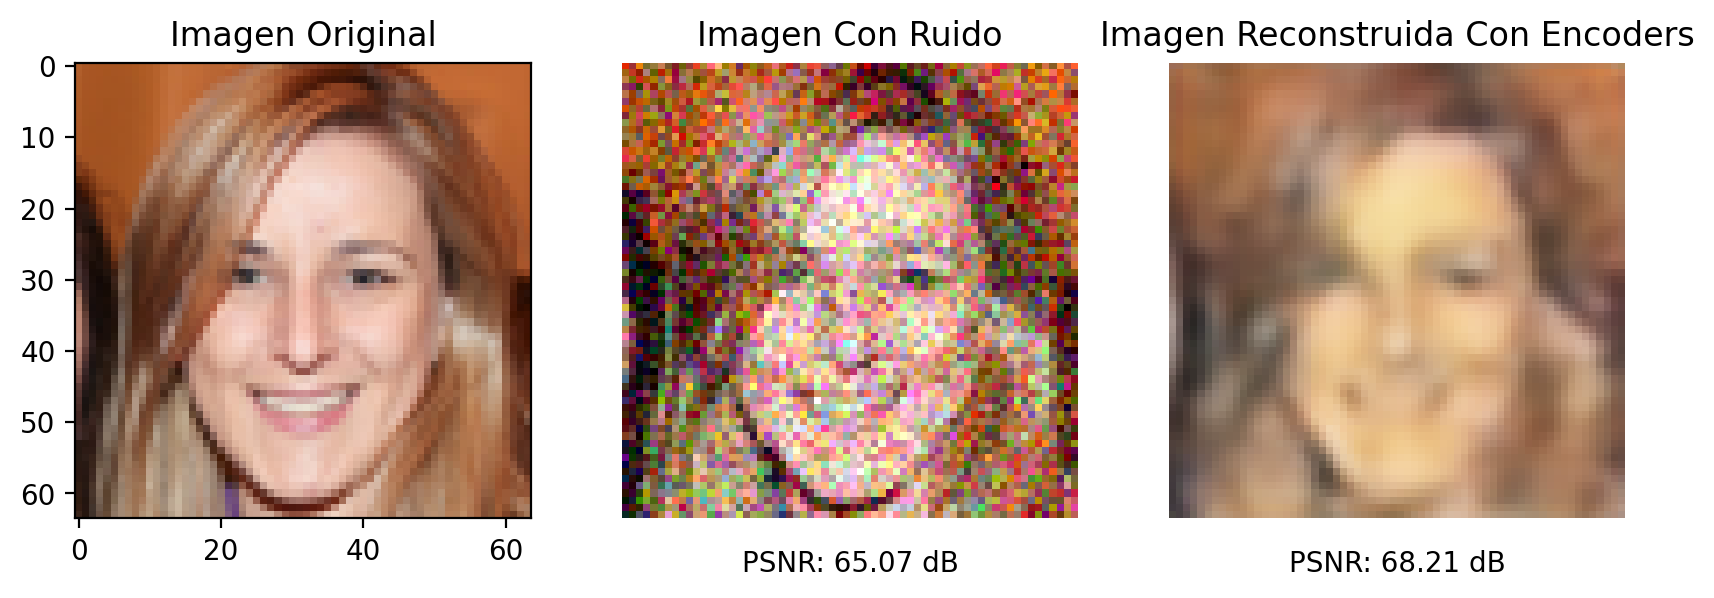

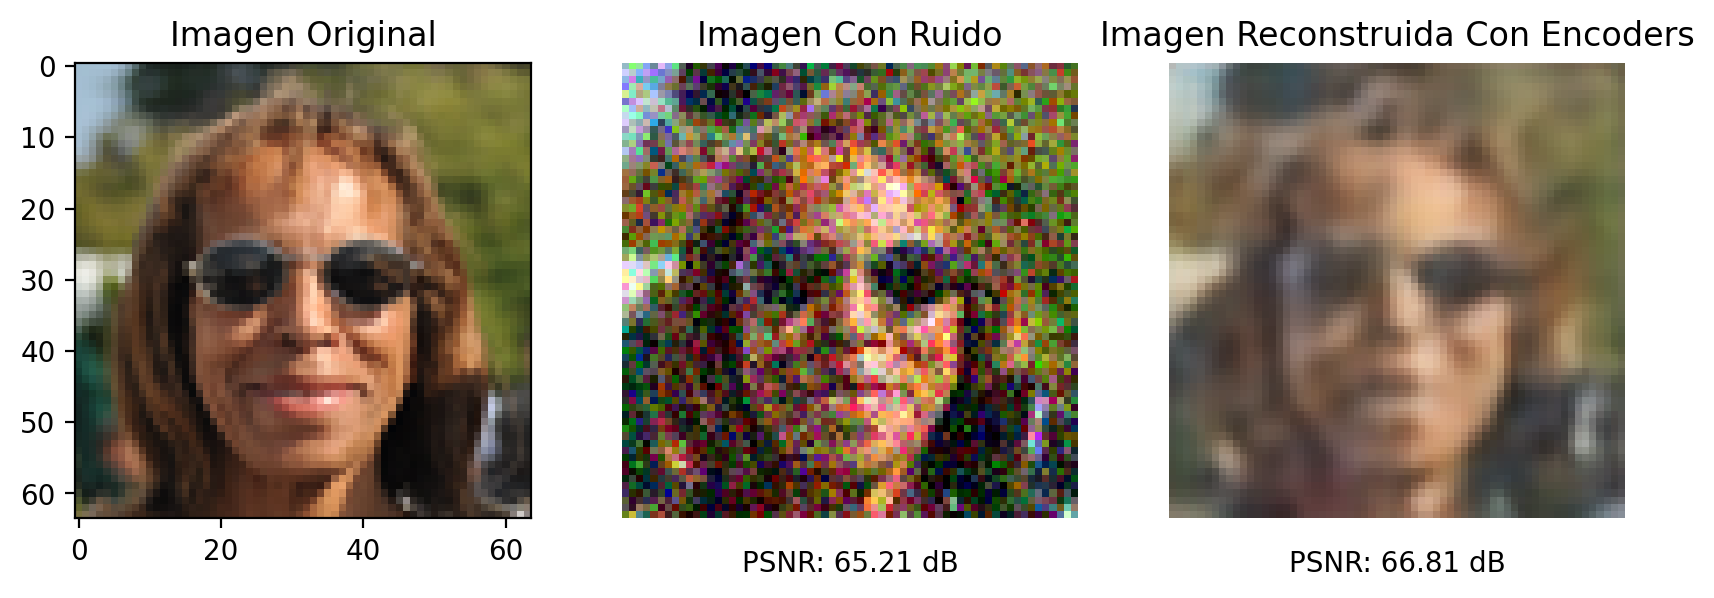

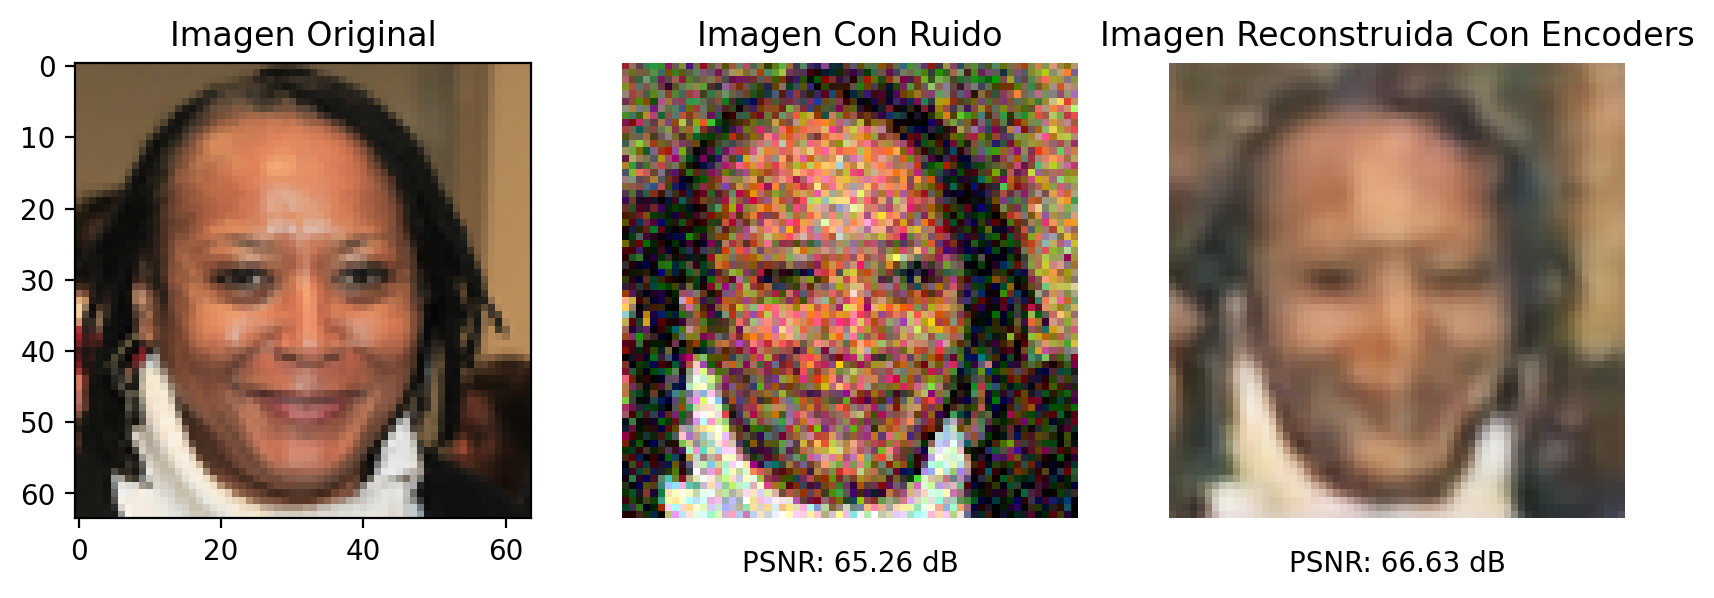

In [ ]:
# Evaluación del modelo
decoded_images = autoencoder.predict(x_test_noisy)
# Visualización de los resultados en comparacion
resultados = 3

for i in range(resultados):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i].reshape(64, 64, 3))
    plt.title('Imagen Original')

    plt.subplot(1, 3, 2)
    plt.imshow(x_test_noisy[i].reshape(64, 64, 3))
    plt.title('Imagen Con Ruido')
    plt.axis('off')
    noisy_psnr = psnr(x_test[i].reshape(64, 64, 3), x_test_noisy[i].reshape(64, 64, 3))
    plt.text(0.5, -0.1, f'PSNR: {noisy_psnr:.2f} dB', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.subplot(1, 3, 3)
    plt.imshow(decoded_images[i].reshape(64, 64, 3))
    plt.title('Imagen Reconstruida Con Encoders')
    plt.axis('off')

    # Calcular PSNR y mostrarlo debajo de la imagen reconstruida
    reconstruida_psnr = psnr(x_test[i].reshape(64, 64, 3), decoded_images[i].reshape(64, 64, 3))
    plt.text(0.5, -0.1, f'PSNR: {reconstruida_psnr:.2f} dB', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.show()

In [ ]:
# Entrenamiento del modelo con sonido Masking
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
autoencoder.fit(x_train_noisy_masking, x_train,
                epochs=20,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test_noisy_masking, x_test,),
                callbacks=[early_stopping])

Epoch 1/20
187/187 [==============================] - 41s 222ms/step - loss: 0.5333 - val_loss: 0.5269
Epoch 2/20
187/187 [==============================] - 40s 215ms/step - loss: 0.5331 - val_loss: 0.5274
Epoch 3/20
187/187 [==============================] - 40s 217ms/step - loss: 0.5330 - val_loss: 0.5267
Epoch 4/20
187/187 [==============================] - 41s 218ms/step - loss: 0.5328 - val_loss: 0.5268
Epoch 5/20
187/187 [==============================] - 41s 222ms/step - loss: 0.5327 - val_loss: 0.5265
Epoch 6/20
187/187 [==============================] - 40s 216ms/step - loss: 0.5325 - val_loss: 0.5264
Epoch 7/20
187/187 [==============================] - 41s 219ms/step - loss: 0.5324 - val_loss: 0.5264
Epoch 8/20
187/187 [==============================] - 40s 215ms/step - loss: 0.5323 - val_loss: 0.5263
Epoch 9/20
187/187 [==============================] - 40s 215ms/step - loss: 0.5322 - val_loss: 0.5263
Epoch 10/20
187/187 [==============================] - 41s 219ms/step - l

Podemos ver que el encoder funciono mejor con el ruido de Masking que con el resto, los niveles de db son mucho mejores que en el resto. Puede que se deba al comportamiento del ruido y la cantidad de datos que preservan y por lo tanto el resultado sea mejor.

Se piensa que con mas epocas y mayor nivel de procesamiento se podrían alcanzar mejores resultados, pero por ahora se logró el objetivo del encoder al suavizar y limpiar las imagenes con ruido.

25/25 [==============================] - 3s 119ms/step


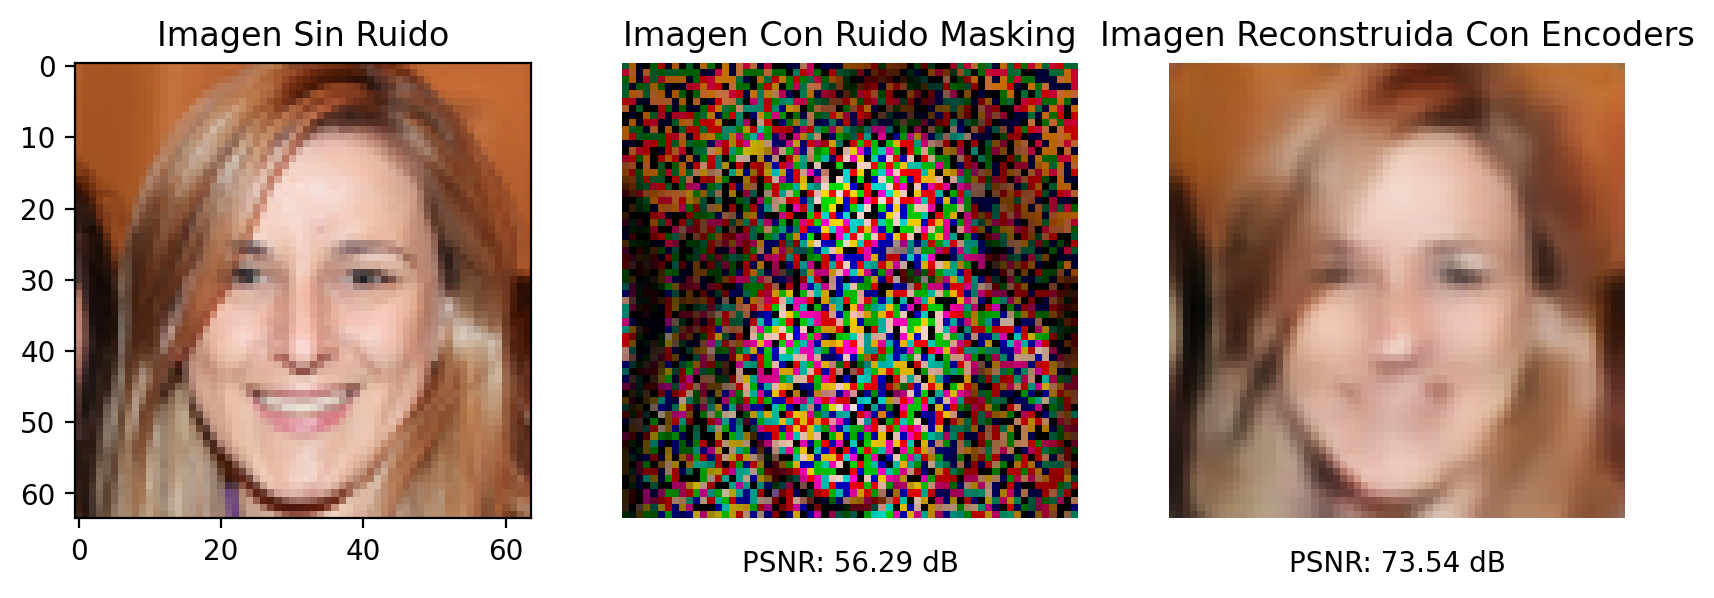

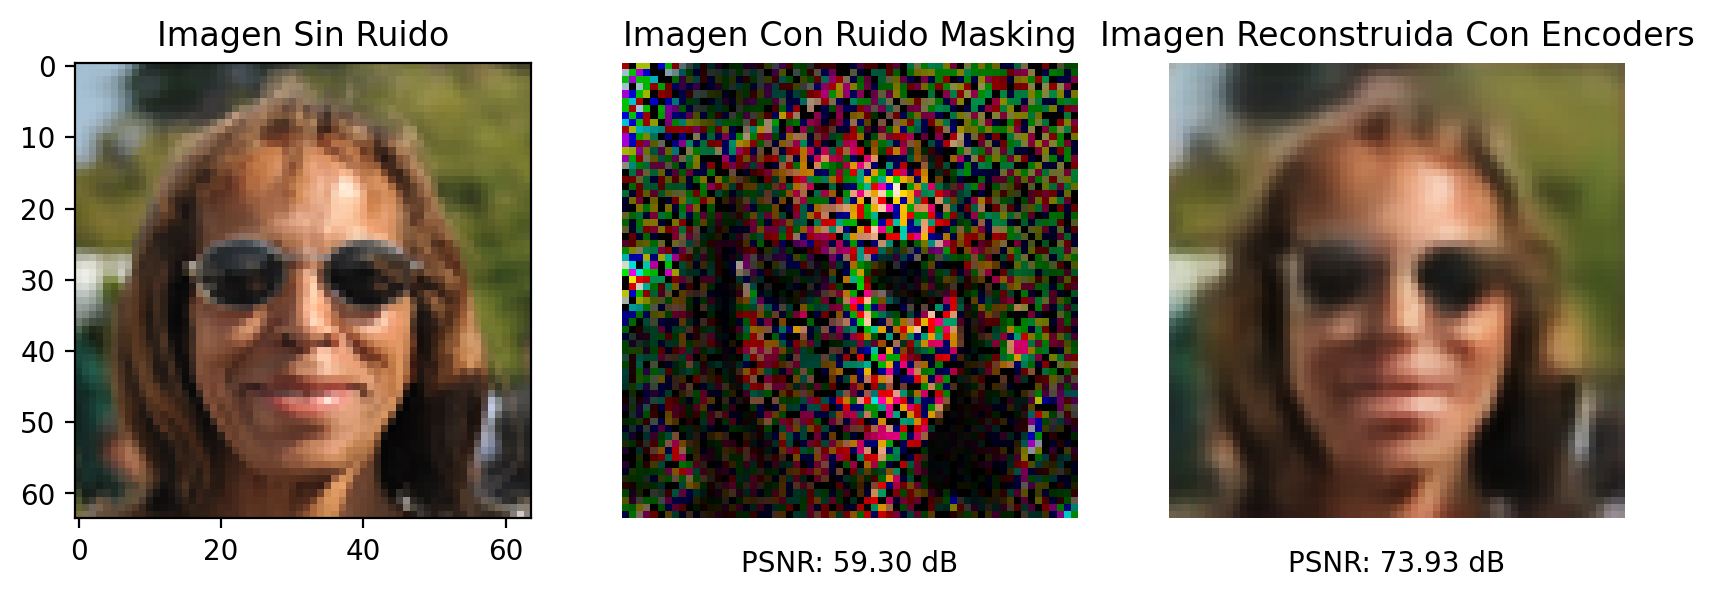

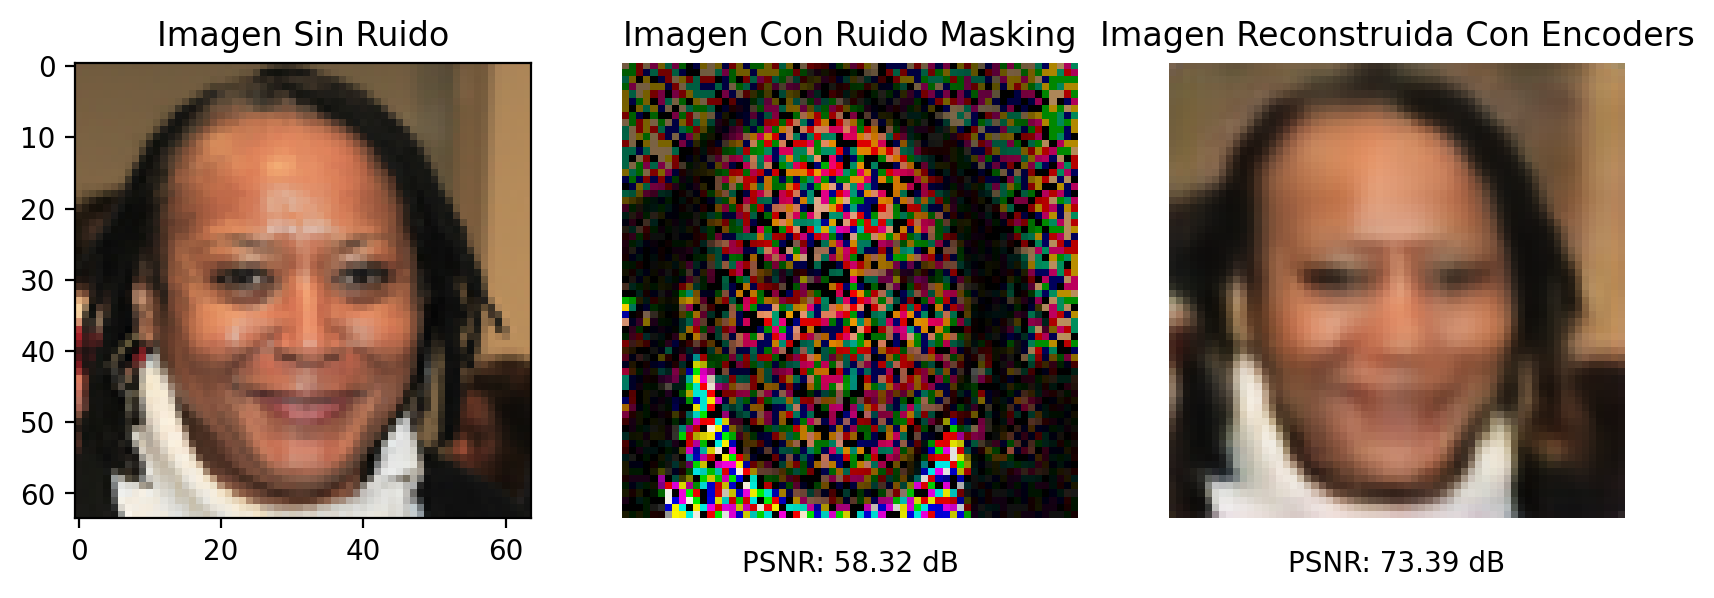

In [ ]:
# Evaluación del modelo
decoded_images = autoencoder.predict(x_test_noisy_masking)
# Visualización de los resultados en comparacion
resultados = 3

for i in range(resultados):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(x_test[i].reshape(64, 64, 3))
    plt.title('Imagen Sin Ruido')

    plt.subplot(1, 3, 2)
    plt.imshow(x_test_noisy_masking[i].reshape(64, 64, 3))
    plt.title('Imagen Con Ruido Masking')
    plt.axis('off')
    noisy_psnr = psnr(x_test[i].reshape(64, 64, 3), x_test_noisy_masking[i].reshape(64, 64, 3))
    plt.text(0.5, -0.1, f'PSNR: {noisy_psnr:.2f} dB', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.subplot(1, 3, 3)
    plt.imshow(decoded_images[i].reshape(64, 64, 3))
    plt.title('Imagen Reconstruida Con Encoders')
    plt.axis('off')

    # Calcular PSNR y mostrarlo debajo de la imagen reconstruida
    reconstruida_psnr = psnr(x_test[i].reshape(64, 64, 3), decoded_images[i].reshape(64, 64, 3))
    plt.text(0.5, -0.1, f'PSNR: {reconstruida_psnr:.2f} dB', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.show()

Podemos ver que el encoder funciono mejor con el ruido de Masking que con el resto, los niveles de db son mucho mejores que en el resto. Puede que se deba al comportamiento del ruido y la cantidad de datos que preservan y por lo tanto el resultado sea mejor.

Se piensa que con mas epocas y mayor nivel de procesamiento se podrían alcanzar mejores resultados, pero por ahora se logró el objetivo del encoder al suavizar y limpiar las imagenes con ruido.